In [1]:
pip install wordcloud 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import pickle
import re

In [3]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [4]:
data = pd.read_csv(r"..\Data\amazon_alexa.tsv", delimiter = '\t', quoting = 3)

In [5]:
print("\nMissing values:\n", data.isnull().sum())
data.dropna(inplace=True)
data.head()


Missing values:
 rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


## corpus = []
    Initializes an empty list called corpus.
    This list will eventually hold the cleaned, preprocessed versions of all reviews.

## stemmer = PorterStemmer()
    Creates an instance of the Porter Stemmer from the nltk library.
    Stemming reduces words to their root form (e.g., "running" → "run", "played" → "play").
    This helps in treating different forms of the same word as one.

In [6]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [7]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [8]:
pickle.dump(cv, open('../Models/countVectorizer.pkl', 'wb'))

In [9]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


In [11]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [12]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [13]:
pickle.dump(scaler, open('../Models/scaler.pkl', 'wb'))

In [14]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9718693284936479
Testing Accuracy : 0.9375661375661376


In [16]:
y_preds = model_xgb.predict(X_test)

In [17]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


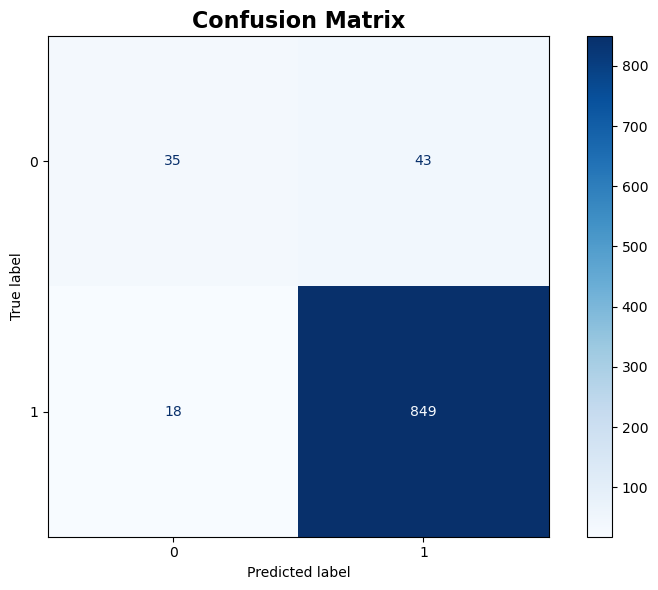

In [18]:
# Create ConfusionMatrixDisplay object with your confusion matrix and class labels
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)

# Plot with a larger figure and a colormap for better visualization
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', colorbar=True, ax=plt.gca())

# Add title and adjust layout
plt.title('Confusion Matrix', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [19]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('../Models/model_xgb.pkl', 'wb'))